# LiveEO MLOps Engineer Challenge

by Jan Niklas Engel

link to git: https://github.com/janedoesrepo/mlops-challenge

## Inference on the test images

We can run inference on the test images by running the code in `scripts/main.py`. The script initializes the arguments that are used to create the model, load a model checkpoint and a instantiate a `DataModule` object. These are subsequently passed to a `Trainer` that can train the model or make predictions.

In order to run inference on the test images, the following command can be used:

```python
python scripts/main.py --base_dir test_images --ckpt_path trained_models/best_model.ckpt
```

While the `base_dir` argument tells the `DataModule` from where to fetch the images and labels(default: 'test_images'), `ckpt_path` points to the weights of the model.

Once inference is run, we can visualize the results.

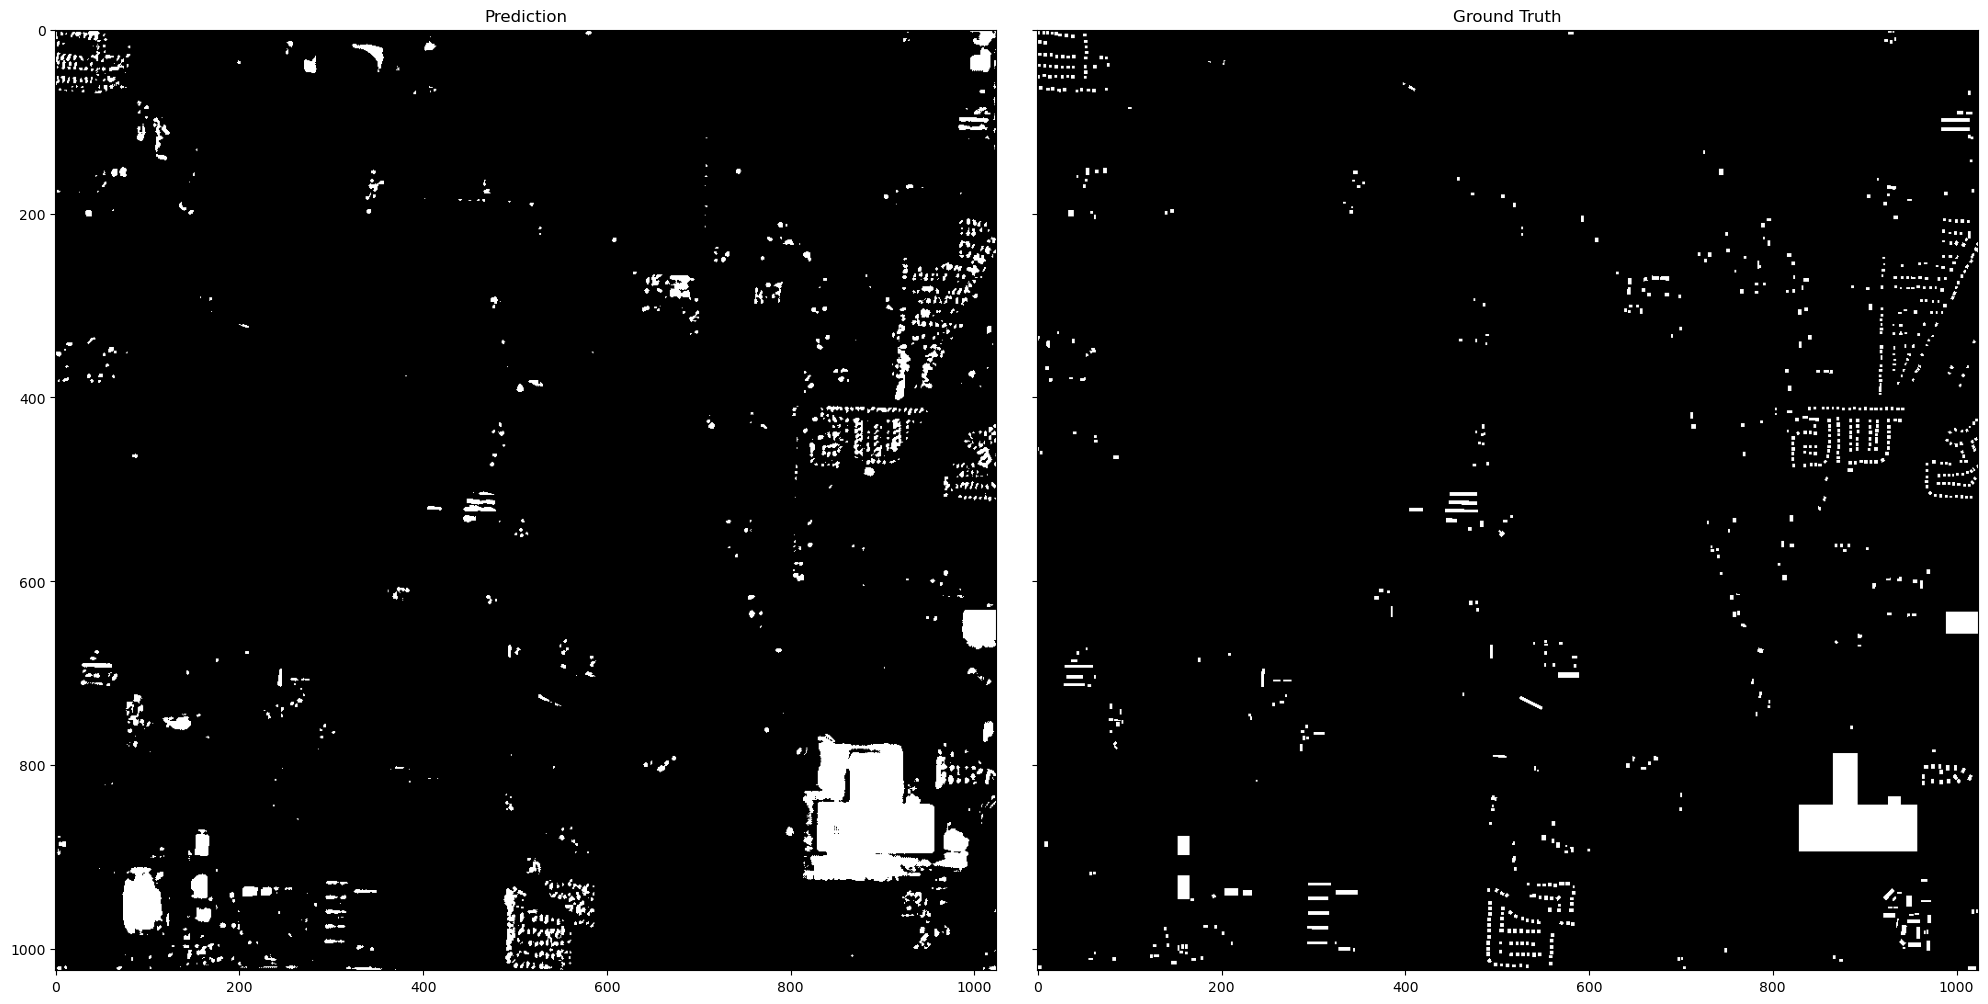

In [1]:
import matplotlib.pyplot as plt
import numpy as np

preds = np.load('./predictions.npy')
lbls = np.load('./labels.npy')

# plot some examples
fig, ax = plt.subplots(1,2, figsize = (20,10), sharey=True)
plt.tight_layout()
ax[0].imshow(preds[3][0], cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(lbls[3][0], cmap='gray')
ax[1].set_title("Ground Truth")
plt.show()

This is the straightforward way to run a fixed command that performs inference on the test images using the best model checkpoint.

## Set up Docker Image

To create the Docker Image we need a `Dockerfile`. This one contains several steps:

1. **Base image**: I use the latest version of python 3.9 to ensure compatibility with the PyTorch library. The slim version uses slightly less space.
2. Setting the environment variable `ENV PYTHONUNBUFFERED=1` disables the buffer for python sdtout and stderr. Otherwise, if the build breaks before the buffer is released, these will now be printed to the console enabling easier debugging.
3. Create a working directory in which the code can be copied.
4. Copy the requirements.txt and create the environment. I use the `--no-cache-dir` option to disable the caching of python packages and get a smaller image.
5. Copy the scripts, test_images, and trained models to the working directory.
6. `RUN` the main script as described in the section above.

The Docker Image can be built using the `docker build --tag <tag> .` command.

## CI Pipeline

The pipeline is triggered when a developer pushes to main. This is a common scenario when the team is working according to the continuous integration paradigma. Alternatively the trigger could be set to push on a pr branch in a branch based workflow. 

### Linting Workflow
I use hadolint for linting the Dockerfile to make sure that the Dokerfile is written according to best practices and guidelines such as using only trusted registries when retrieving images. 

### Docker Image CI Workflow
1. **Build against multiple environments**: Set up qemu to build the image against multiple environments. This assures that the image can be built and the container be run on different chip architecturesof the laptop that developers might be using.
2. **Enable Layer Caching**: Set up buildx to enable caching of the image layers. This will lead to much faster build times in the next step. It is enabled by setting the `cache-from/-to` args to ``gha` github actions.
3. **Build Image**: Actually build the docker image against multiple platforms in parallel using qemu.

## Future possible features

### Pre-commit hooks
Add the following actions to the CI Pipeline to make sure that pre-commit has been installed locally. 
- **Isort** for imports sorting
- **Flake8** for linting
- **Black** for formatting

### Requirements.txt

- **Reproducibility**: Create a new `requirements.txt` to freeze package versions and make the envrionment reproducible. Otherwise newer versions of packages might be downloaded which can break the code.

### Dockerfile
- **Mount a volume** where the predictions are stored to access them locally

### Further CI

- Write **unit tests** for the code
- **Integration tests** with docker compose
- Check for common vulnarabilities and exposures (**CVE testing**)
- **Dynamically tag images** to see which model will be executed within the container. This way we always know from which model the predictions come from. 
- **Push Docker Image to a registry**, like Docker Hub